In [1]:
import sys
import os

# Add the root directory to the Python environment
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_dir)

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv("../data/aggregated/aggregated_1752501542.csv.gz", compression="gzip")
df.head()

,coin,err,algo_time,algo,block,prep_time,n_nodes,n_edges,top_coin_count,avg_time,is_timeout,is_failed
0,0x89a8c847f41c0dfa6c8b88638bacca8a0b777da7,timeout: Algorithm execution timed out,12.000070,mmbf,22830752,4.768372e-07,1000,4416,1000,12.00007,True,False
1,0xfa14fa6958401314851a17d6c5360ca29f74b57b,timeout: Algorithm execution timed out,12.000070,mmbf,22830752,4.768372e-07,1000,4416,1000,NaN,True,False
2,0xee2a03aa6dacf51c18679c516ad5283d8e7c2637,timeout: Algorithm execution timed out,12.000067,mmbf,22830752,4.768372e-07,1000,4416,1000,NaN,True,False
3,0xcc4304a31d09258b0029ea7fe63d032f52e44efe,timeout: Algorithm execution timed out,12.000068,mmbf,22830752,4.768372e-07,1000,4416,1000,NaN,True,False
4,0x7afebbb46fdb47ed17b22ed075cde2447694fb9e,timeout: Algorithm execution timed out,12.000070,mmbf,22830752,4.768372e-07,1000,4416,1000,NaN,True,False


In [9]:
df = df[(df['block'] >= 22820000) & (df['block'] <= 22839999)]

In [18]:
df[((df['algo']=='bf') | (df['algo']=='ours')) & (df['is_timeout']==False)].groupby(['algo'])['avg_time'].mean()

algo
bf      0.594721
ours    0.054057
Name: avg_time, dtype: float64

In [10]:
# Filter out rows where is_timeout is False (i.e., solved)
df_no_timeout = df[df['is_timeout'] == False]

# Group by 'algo' and 'top_coin_count', then calculate the mean of 'avg_time' (excluding NaNs)
# Also count the number of solved instances
grouped = df_no_timeout.groupby(['algo', 'top_coin_count'])
avg_time_per_algo = grouped['avg_time'].mean().reset_index()
num_queries = grouped.size().reset_index(name='num_queries')

# Merge the two results
avg_time_per_algo = avg_time_per_algo.merge(num_queries, on=['algo', 'top_coin_count'])

# Rename the column for clarity
avg_time_per_algo = avg_time_per_algo.rename(columns={'avg_time': 'total_avg_time'})

# Rename 'algo' values for better display
algo_rename_map = {
    'bf': 'BF',
    'mmbf': 'MMBF',
    'ours': 'Hermes (Ours)'
}
avg_time_per_algo['algo'] = avg_time_per_algo['algo'].replace(algo_rename_map)

# Display the result
avg_time_per_algo



,algo,top_coin_count,total_avg_time,num_queries
0,BF,100,0.015813,2000000
1,BF,1000,1.165330,2000000
2,BF,10000,1.130442,23741
3,BF,100000,0.815489,16511
4,MMBF,100,2.819070,1999998
5,Hermes (Ours),100,0.000216,2000000
6,Hermes (Ours),1000,0.002139,2000000
7,Hermes (Ours),10000,0.019673,2000000
8,Hermes (Ours),100000,0.194198,2000000


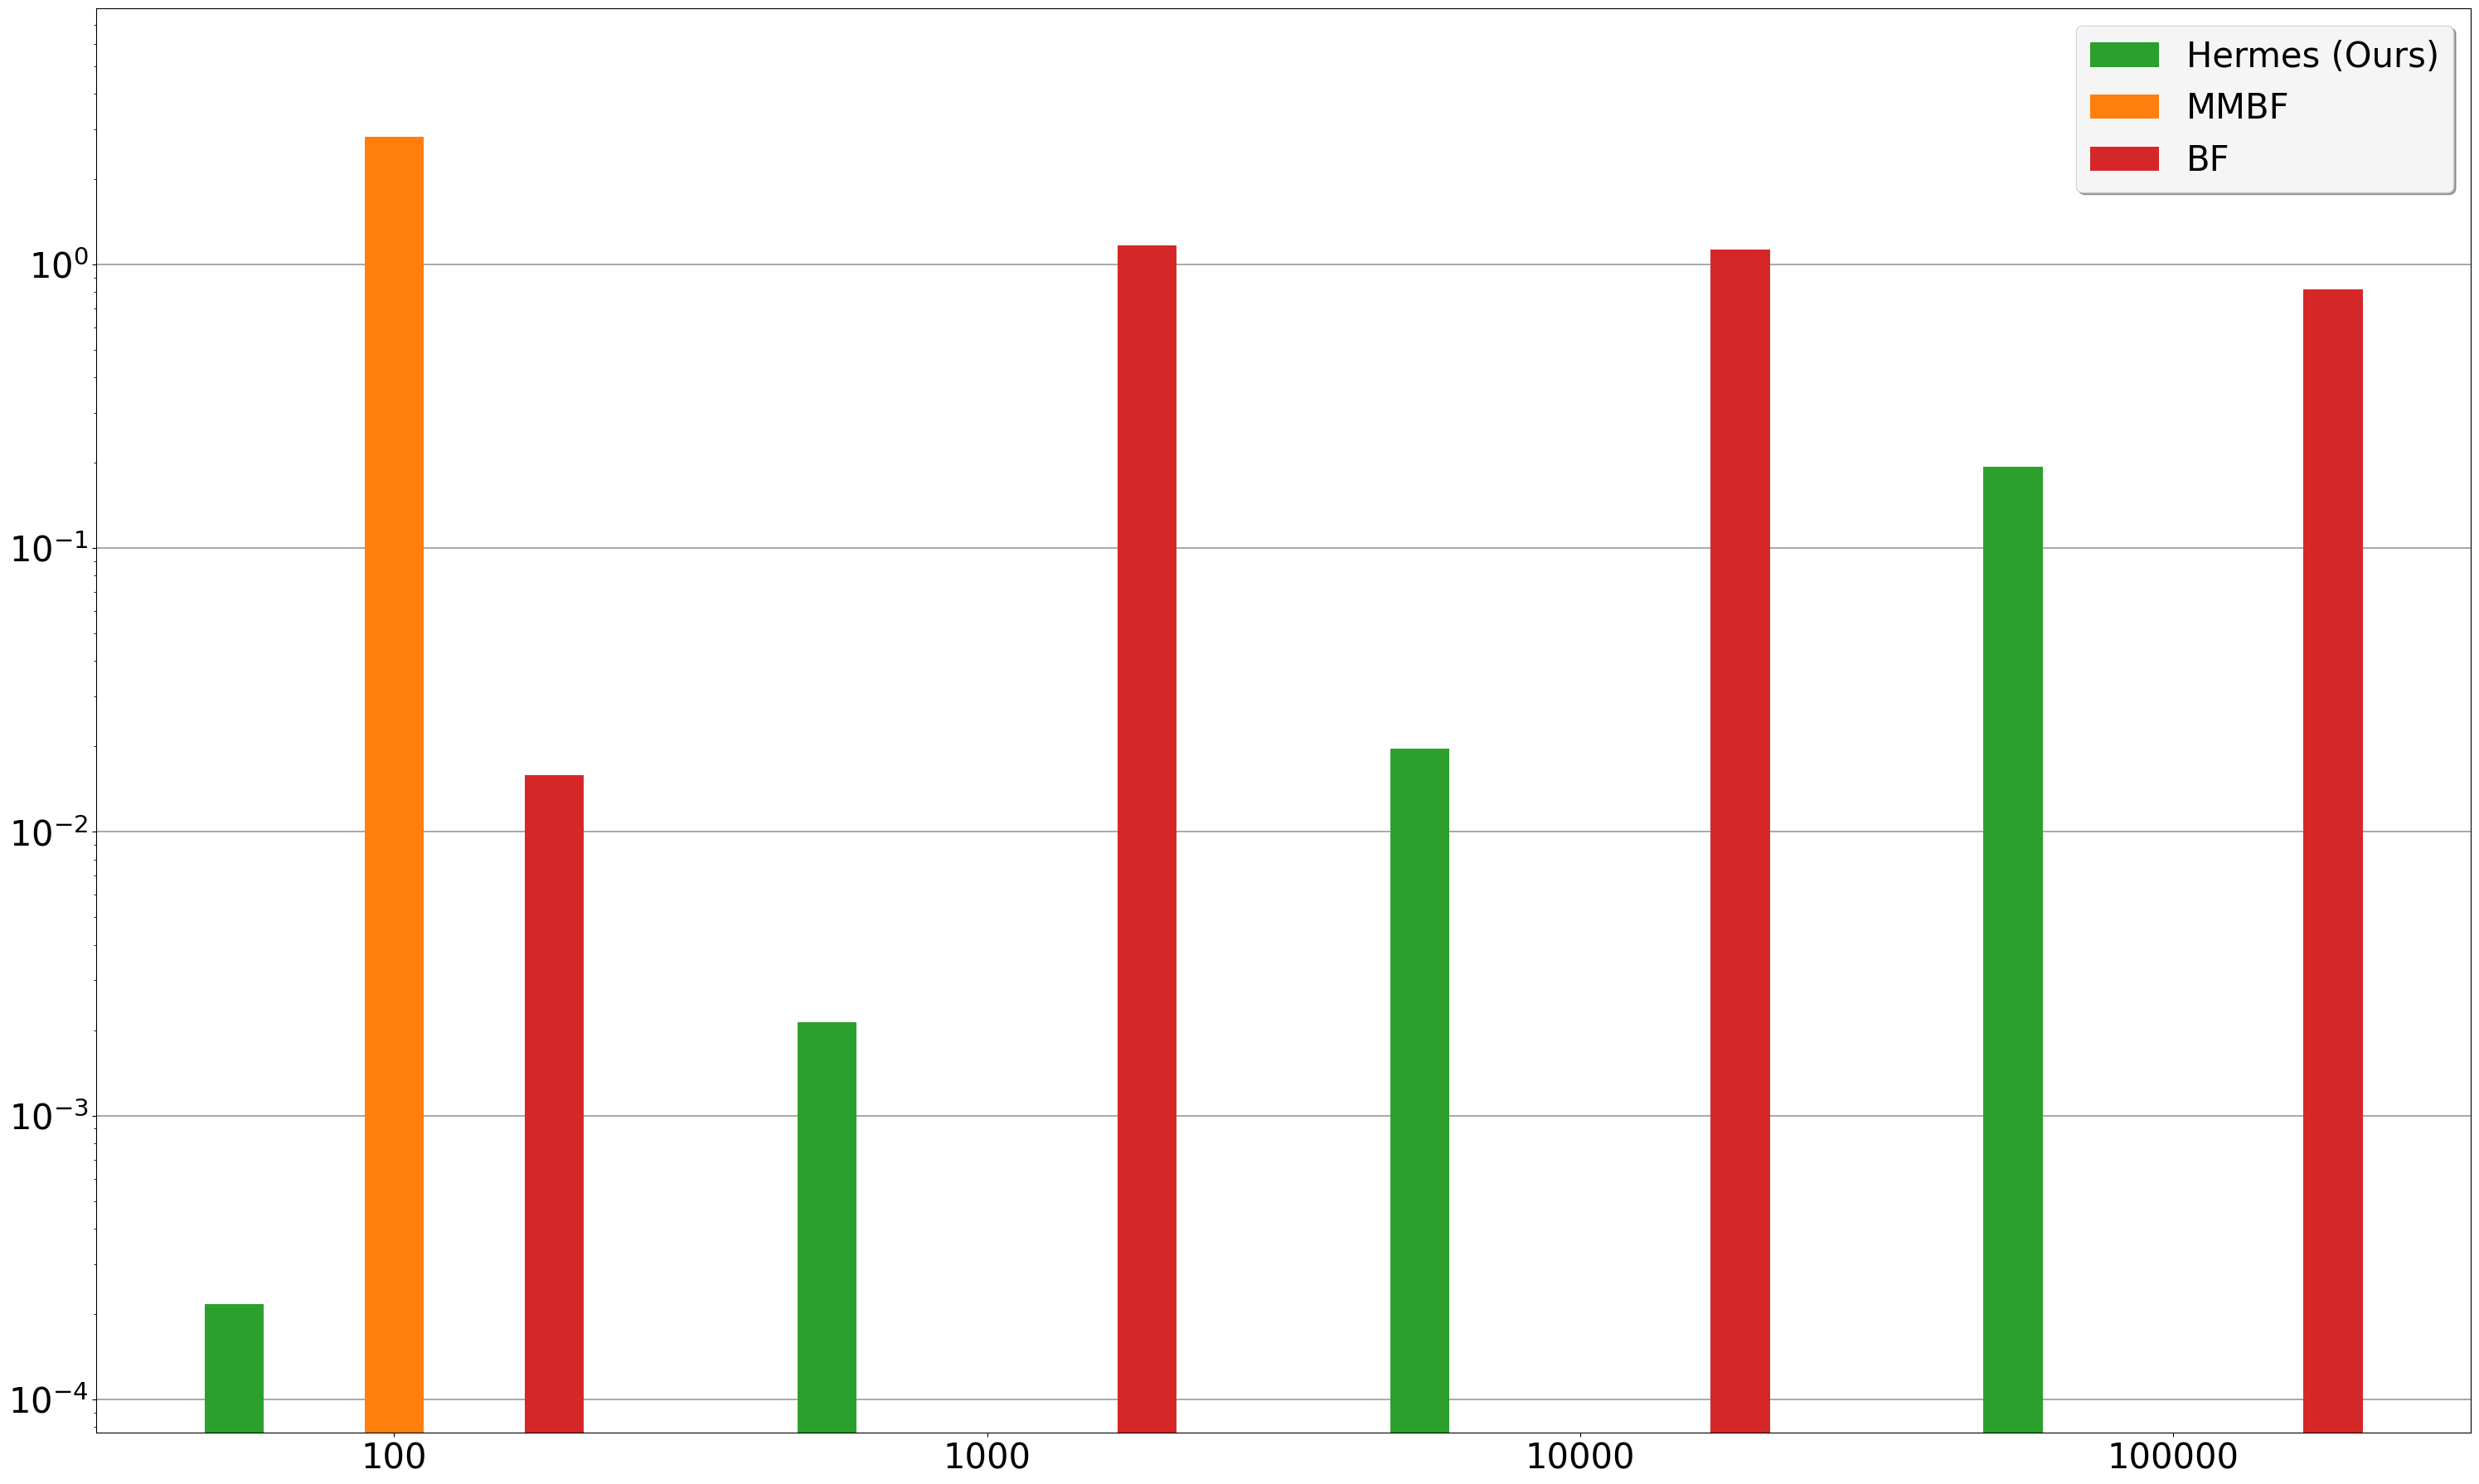


Performance Comparison Table:
algo            Hermes (Ours)     MMBF       BF
top_coin_count                                 
100                  0.000216 2.819070 0.015813
1000                 0.002139      NaN 1.165330
10000                0.019673      NaN 1.130442
100000               0.194198      NaN 0.815489


In [11]:
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Define the coin counts to display, in desired order
counts = [100, 1000, 10000, 100000]

# Define the desired algorithm display order
algo_order = ['Hermes (Ours)', 'MMBF', 'BF']

# Filter and sort the DataFrame for the selected coin counts and desired algo order
plot_df = avg_time_per_algo[avg_time_per_algo['top_coin_count'].isin(counts)].copy()
plot_df['top_coin_count'] = pd.Categorical(plot_df['top_coin_count'], categories=counts, ordered=True)
plot_df['algo'] = pd.Categorical(plot_df['algo'], categories=algo_order, ordered=True)
plot_df = plot_df.sort_values(['top_coin_count', 'algo'])

# Use matplotlib color palette and set custom colors: Hermes (Ours) = green, MMBF = orange, BF = red
tab10_colors = plt.cm.tab10.colors
algo_colors = {
    'Hermes (Ours)': sns.color_palette("tab10")[2],  # Green
    'MMBF': sns.color_palette("tab10")[1],           # Orange
    'BF': sns.color_palette("tab10")[3],             # Red
}

# Create figure with better size
fig, ax = plt.subplots(figsize=(30, 18))

# Prepare data for grouped bar chart
x_labels = [str(count) for count in counts]
x_pos = np.arange(len(x_labels))
bar_width = 0.1
bar_spacing = 0.17  # Add space between bars
bars = []

# Create grouped bars manually
for i, algo in enumerate(algo_order):
    algo_data = plot_df[plot_df['algo'] == algo]
    heights = []
    query_counts = []
    
    for count in counts:
        row = algo_data[algo_data['top_coin_count'] == count]
        if not row.empty:
            heights.append(row['total_avg_time'].iloc[0])
            query_counts.append(row['num_queries'].iloc[0])
        else:
            heights.append(0)
            query_counts.append(0)
    
    # Add spacing between bars by using (bar_width + bar_spacing) for positioning
    bars.append(ax.bar((x_pos + i * (bar_width + bar_spacing)), heights, bar_width, 
                      label=algo, color=algo_colors[algo])) 

    
    # Annotate bars with values, rotated 45 degrees, centered after rotation
    # for j, (height, num_queries) in enumerate(zip(heights, query_counts)):
    #     if height > 0:
    #         rounded_height = np.ceil(height * 1000) / 1000
    #         #{float(num_queries/1000)}K
    #         text = f'{rounded_height:.3f}(s)\n({num_queries})'
    #         # Center the annotation horizontally on the bar
    #         ax.annotate(
    #             text,
    #             ((x_pos[j] + i * (bar_width + bar_spacing) + bar_width - 0.2 / 2), height),
    #             ha='center', va='center', fontsize=48,
    #             color='black',
    #             xytext=(0, 55),  # Move even further above the bar for more height
    #             textcoords='offset points',
    #             zorder=10,
    #             clip_on=False,
    #             # rotation=90
    #         )

# Set x-axis labels and positioning
# ax.set_xlabel('Number of Tokens', fontsize=40, labelpad=12)
# ax.set_ylabel('Average Run Time (s)', fontsize=40, labelpad=12)
# Center the x-axis ticks among the three bars
ax.set_xticks(x_pos + (len(algo_order) - 1) * (bar_width + bar_spacing) / 2)
ax.set_xticklabels(x_labels, fontsize=30)  # Make x-axis tick labels bigger

# Make y-axis tick labels bigger
ax.tick_params(axis='y', labelsize=30)
ax.tick_params(axis='x', labelsize=30)

# Improve legend
legend = ax.legend(loc='upper right', 
                  frameon=True, fancybox=True, shadow=True,
                  fontsize=30)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Add grid for better readability
# ax.set_ylim(0, 1.1)
# ax.yaxis.set_ticks(np.arange(0, 1.1 + 0.1, 0.1))
ax.grid(True, alpha=0.8, linestyle='-', axis='y', color='gray', linewidth=1.2)
ax.margins(y=0.11)
ax.set_axisbelow(True)

# Adjust layout
plt.tight_layout()
plt.savefig('../data/comparison_of_algs.pdf', 
            dpi=500, 
            format='pdf', 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')
plt.show()

# Print performance comparison table
print("\nPerformance Comparison Table:")
print("=" * 50)
pivot_table = plot_df.pivot(index='top_coin_count', columns='algo', values='total_avg_time')
print(pivot_table.to_string(float_format='%.6f'))



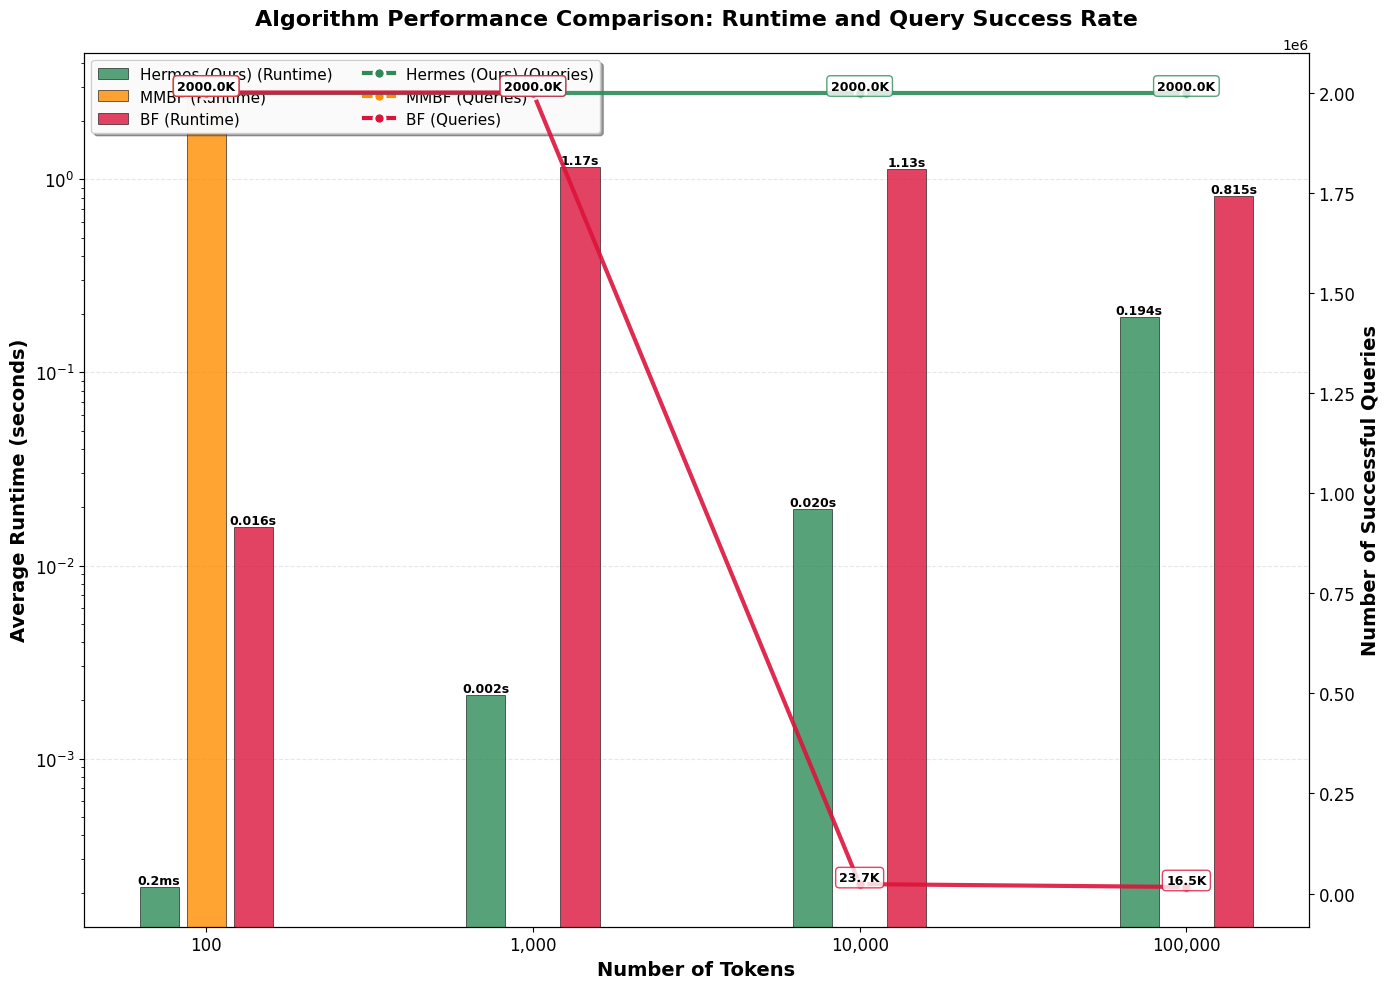


ALGORITHM PERFORMANCE COMPARISON WITH QUERY STATISTICS

Average Runtime (seconds):
--------------------------------------------------
algo            Hermes (Ours)     MMBF       BF
top_coin_count                                 
100                  0.000216 2.819070 0.015813
1000                 0.002139  TIMEOUT 1.165330
10000                0.019673  TIMEOUT 1.130442
100000               0.194198  TIMEOUT 0.815489

Number of Successful Queries:
--------------------------------------------------
algo            Hermes (Ours)    MMBF      BF
top_coin_count                               
100                   2000000 1999998 2000000
1000                  2000000 TIMEOUT 2000000
10000                 2000000 TIMEOUT   23741
100000                2000000 TIMEOUT   16511

Performance Analysis:
--------------------------------------------------

Dataset: 100 tokens
  Algorithm    Runtime(s)  Queries  Success Rate  Speedup vs BF
  ----------------------------------------------------------

In [12]:
# Publication-Quality Algorithm Performance Comparison Plot (Single Plot with Dual Y-Axes)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Set publication-ready style
plt.style.use('default')
sns.set_palette("husl")

# Define the datasets and algorithms for comparison
datasets = [100, 1000, 10000, 100000]
algorithms = ['Hermes (Ours)', 'MMBF', 'BF']

# Prepare data for plotting
plot_data = avg_time_per_algo[avg_time_per_algo['top_coin_count'].isin(datasets)].copy()
plot_data['top_coin_count'] = pd.Categorical(plot_data['top_coin_count'], categories=datasets, ordered=True)
plot_data['algo'] = pd.Categorical(plot_data['algo'], categories=algorithms, ordered=True)
plot_data = plot_data.sort_values(['top_coin_count', 'algo'])

# Create color palette for algorithms
colors = {
    'Hermes (Ours)': '#2E8B57',  # Sea Green
    'MMBF': '#FF8C00',           # Dark Orange  
    'BF': '#DC143C'              # Crimson
}

# Create the figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 10))

# Set up bar chart parameters
x_labels = [f'{count:,}' for count in datasets]
x_pos = np.arange(len(x_labels))
bar_width = 0.12
x_offset = np.array([-bar_width*1.2, 0, bar_width*1.2])

# ============ PRIMARY Y-AXIS: Runtime Performance (Bars) ============
runtime_bars = []
for i, algo in enumerate(algorithms):
    algo_data = plot_data[plot_data['algo'] == algo]
    times = []
    
    # Extract timing data for each dataset
    for dataset in datasets:
        rows = algo_data[algo_data['top_coin_count'] == dataset]
        if not rows.empty and not pd.isna(rows['total_avg_time'].iloc[0]):
            times.append(rows['total_avg_time'].iloc[0])
        else:
            times.append(None)  # Handle missing data
    
    # Create bars, handling None values
    valid_indices = [j for j, time in enumerate(times) if time is not None]
    valid_times = [times[j] for j in valid_indices]
    valid_positions = [x_pos[j] + x_offset[i] for j in valid_indices]
    
    bars = ax1.bar(valid_positions, valid_times, bar_width, 
                  label=f'{algo} (Runtime)', color=colors[algo], alpha=0.8, 
                  edgecolor='black', linewidth=0.5)
    runtime_bars.append(bars)
    
    # Add value labels on bars
    for bar, time in zip(bars, valid_times):
        height = bar.get_height()
        if height > 0:
            # Format time display based on magnitude
            if height < 0.001:
                label = f'{height*1000:.1f}ms'
            elif height < 1:
                label = f'{height:.3f}s'
            else:
                label = f'{height:.2f}s'
            
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                   label, ha='center', va='bottom', fontsize=9, fontweight='bold')

# ============ SECONDARY Y-AXIS: Query Counts (Lines with Markers) ============
ax2 = ax1.twinx()

query_lines = []
for i, algo in enumerate(algorithms):
    algo_data = plot_data[plot_data['algo'] == algo]
    query_counts = []
    x_positions = []
    
    # Extract query count data for each dataset
    for j, dataset in enumerate(datasets):
        rows = algo_data[algo_data['top_coin_count'] == dataset]
        if not rows.empty and not pd.isna(rows['num_queries'].iloc[0]):
            query_counts.append(rows['num_queries'].iloc[0])
            x_positions.append(x_pos[j])
    
    # Create lines with markers
    if query_counts:  # Only plot if we have data
        line = ax2.plot(x_positions, query_counts, 'o-', 
                       color=colors[algo], linewidth=3, markersize=8, 
                       label=f'{algo} (Queries)', alpha=0.9, markeredgecolor='white', markeredgewidth=2)
        query_lines.append(line)
        
        # Add value labels on markers
        for x, count in zip(x_positions, query_counts):
            # Format count display
            if count >= 1000:
                label = f'{count/1000:.1f}K'
            else:
                label = f'{int(count)}'
            
            ax2.text(x, count, label, ha='center', va='bottom', fontsize=9, 
                    fontweight='bold', bbox=dict(boxstyle='round,pad=0.3', 
                    facecolor='white', alpha=0.8, edgecolor=colors[algo]))

# Customize primary y-axis (Runtime)
ax1.set_xlabel('Number of Tokens', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average Runtime (seconds)', fontsize=14, fontweight='bold', color='black')
ax1.set_title('Algorithm Performance Comparison: Runtime and Query Success Rate', 
             fontsize=16, fontweight='bold', pad=20)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x_labels, fontsize=12)
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelsize=12, colors='black')
ax1.grid(True, alpha=0.3, linestyle='--', axis='y')
ax1.set_axisbelow(True)

# Customize secondary y-axis (Query Counts)
ax2.set_ylabel('Number of Successful Queries', fontsize=14, fontweight='bold', color='black')
ax2.tick_params(axis='y', labelsize=12, colors='black')

# Create combined legend
runtime_handles = [bars[0] if bars else None for bars in runtime_bars]
runtime_labels = [f'{algo} (Runtime)' for algo in algorithms]

query_handles = []
query_labels = []
for i, algo in enumerate(algorithms):
    algo_data = plot_data[plot_data['algo'] == algo]
    # Check if this algorithm has query data
    has_query_data = any(not pd.isna(row['num_queries']) for _, row in algo_data.iterrows())
    if has_query_data:
        # Create a dummy line for legend
        line = plt.Line2D([0], [0], color=colors[algo], linewidth=3, marker='o', markersize=8, 
                         markeredgecolor='white', markeredgewidth=2)
        query_handles.append(line)
        query_labels.append(f'{algo} (Queries)')

# Combine all handles and labels
all_handles = [h for h in runtime_handles if h is not None] + query_handles
all_labels = [runtime_labels[i] for i, h in enumerate(runtime_handles) if h is not None] + query_labels

legend = ax1.legend(all_handles, all_labels, loc='upper left', frameon=True, 
                   fancybox=True, shadow=True, fontsize=11, ncol=2)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.95)

# Adjust layout and save
plt.tight_layout()

# Save as high-resolution PDF for publication
plt.savefig('../data/algorithm_performance_combined.pdf', 
            dpi=300, format='pdf', bbox_inches='tight',
            facecolor='white', edgecolor='none')

# Save as PNG for presentations
plt.savefig('../data/algorithm_performance_combined.png', 
            dpi=300, format='png', bbox_inches='tight',
            facecolor='white', edgecolor='none')

plt.show()

# Print comprehensive performance statistics
print("\n" + "="*80)
print("ALGORITHM PERFORMANCE COMPARISON WITH QUERY STATISTICS")
print("="*80)

# Create pivot tables for runtime and query counts
runtime_table = plot_data.pivot(index='top_coin_count', columns='algo', values='total_avg_time')
query_table = plot_data.pivot(index='top_coin_count', columns='algo', values='num_queries')

print(f"\nAverage Runtime (seconds):")
print("-" * 50)
print(runtime_table.to_string(float_format='%.6f', na_rep='TIMEOUT'))

print(f"\nNumber of Successful Queries:")
print("-" * 50)
print(query_table.to_string(float_format='%.0f', na_rep='TIMEOUT'))

# Calculate success rates and speedup ratios
print(f"\nPerformance Analysis:")
print("-" * 50)
for dataset in datasets:
    print(f"\nDataset: {dataset:,} tokens")
    print("  Algorithm    Runtime(s)  Queries  Success Rate  Speedup vs BF")
    print("  " + "-" * 60)
    
    for algo in algorithms:
        runtime = runtime_table.loc[dataset, algo] if pd.notna(runtime_table.loc[dataset, algo]) else None
        queries = query_table.loc[dataset, algo] if pd.notna(query_table.loc[dataset, algo]) else None
        
        if runtime is not None and queries is not None:
            # Calculate success rate (assuming some baseline total queries)
            success_rate = "Available"
            
            # Calculate speedup compared to BF
            bf_runtime = runtime_table.loc[dataset, 'BF'] if pd.notna(runtime_table.loc[dataset, 'BF']) else None
            if bf_runtime is not None and runtime > 0:
                speedup = f"{bf_runtime/runtime:.1f}x"
            else:
                speedup = "N/A"
            
            print(f"  {algo:<12} {runtime:>8.6f}  {queries:>7.0f}  {success_rate:>11}  {speedup:>10}")
        else:
            print(f"  {algo:<12} {'TIMEOUT':>8}  {'N/A':>7}  {'N/A':>11}  {'N/A':>10}")

print("\n" + "="*80)


In [14]:
# Generate LaTeX table from avg_time_per_algo data using the same style as success_rate_table
from textwrap import dedent

def generate_latex_table_sideways(df):
    """
    Generate LaTeX table code from the avg_time_per_algo DataFrame
    using the same formatting style as the success_rate_table
    
    Parameters:
    df: DataFrame with columns ['algo', 'top_coin_count', 'total_avg_time', 'num_queries']
    
    Returns:
    string: LaTeX table code
    """
    
    # Pivot the data
    runtime_pivot = df.pivot(index='top_coin_count', columns='algo', values='total_avg_time')
    queries_pivot = df.pivot(index='top_coin_count', columns='algo', values='num_queries')
    
    # Define algorithm order and display names
    algo_order = [('Hermes (Ours)', 'Hermes'), ('MMBF', 'MMBF'), ('BF', 'BF')]
    row_order = [100, 1000, 10000, 100000]
    
    # Helper function to get values for a given algo and top_coin_count
    def get_row_values(algo, tcc):
        runtime = runtime_pivot.loc[tcc, algo] if pd.notna(runtime_pivot.loc[tcc, algo]) else None
        queries = queries_pivot.loc[tcc, algo] if pd.notna(queries_pivot.loc[tcc, algo]) else None
        
        if runtime is not None and queries is not None:
            runtime_str = f"{runtime:.6f}"
            queries_str = f"{int(queries):,}"
            # Calculate speedup vs BF
            bf_runtime = runtime_pivot.loc[tcc, 'BF'] if pd.notna(runtime_pivot.loc[tcc, 'BF']) else None
            if bf_runtime is not None and runtime > 0:
                speedup = bf_runtime / runtime
                speedup_str = f"{speedup:.1f}$\\times$"
            else:
                speedup_str = "N/A"
            return runtime_str, queries_str, speedup_str
        else:
            return "TIMEOUT", "0", "N/A"
    
    # Build LaTeX table header
    header = dedent(r"""
    \begin{sidewaystable}[htbp]
    \small
    \centering
    \begin{tabular}{|l|ccc|ccc|ccc|}
    \hline
    & \multicolumn{3}{c|}{Hermes} & \multicolumn{3}{c|}{MMBF} & \multicolumn{3}{c|}{BF} \\
    \cline{2-10}
    & Runtime (s) & Queries & Speedup & Runtime (s) & Queries & Speedup & Runtime (s) & Queries & Speedup \\
    \hline
    """).strip().splitlines()
    
    latex_table = [line.rstrip() for line in header]
    
    # Add data rows
    for tcc in row_order:
        row_cells = []
        for algo, _ in algo_order:
            runtime_str, queries_str, speedup_str = get_row_values(algo, tcc)
            row_cells.extend([runtime_str, queries_str, speedup_str])
        
        row_line = f"{tcc:,}"
        for i in range(0, len(row_cells), 3):
            row_line += f" & {row_cells[i]} & {row_cells[i+1]} & {row_cells[i+2]}"
        row_line += r" \\"
        latex_table.append(row_line)
    
    # Add table footer
    latex_table.extend([
        r"\hline",
        r"\end{tabular}",
        r"\caption{Algorithm Performance Comparison: Runtime, Query Success, and Speedup Analysis}",
        r"\label{tab:algorithm_performance_comparison}",
        r"\end{sidewaystable}"
    ])
    
    return "\n".join(latex_table)

def generate_compact_table(df):
    """
    Generate a compact LaTeX table focused on the most important metrics
    """
    runtime_pivot = df.pivot(index='top_coin_count', columns='algo', values='total_avg_time')
    queries_pivot = df.pivot(index='top_coin_count', columns='algo', values='num_queries')
    
    row_order = [100, 1000, 10000, 100000]
    
    header = dedent(r"""
    \begin{table}[htbp]
    \small
    \centering
    \begin{tabular}{|l|cc|cc|cc|}
    \hline
    & \multicolumn{2}{c|}{Hermes (Ours)} & \multicolumn{2}{c|}{MMBF} & \multicolumn{2}{c|}{BF} \\
    \cline{2-7}
    \begin{tabular}[c]{@{}c@{}}Number of\\Tokens\end{tabular} & Runtime & Completed & Runtime & Completed & Runtime & Completed \\
    \hline
    """).strip().splitlines()
    
    latex_table = [line.rstrip() for line in header]
    
    # Add data rows
    for tcc in row_order:
        row_line = f"{tcc:,}"
        
        for algo in ['Hermes (Ours)', 'MMBF', 'BF']:
            runtime = runtime_pivot.loc[tcc, algo] if pd.notna(runtime_pivot.loc[tcc, algo]) else None
            queries = queries_pivot.loc[tcc, algo] if pd.notna(queries_pivot.loc[tcc, algo]) else None
            
            if runtime is not None and queries is not None:
                runtime_str = f"{runtime:.4f}s"
                completed_str = f"{int(queries):,}"
                row_line += f" & {runtime_str} & {completed_str}"
            else:
                row_line += f" & TIMEOUT & 0"
        
        row_line += r" \\"
        latex_table.append(row_line)
    
    # Add table footer
    latex_table.extend([
        r"\hline",
        r"\end{tabular}",
        r"\caption{Algorithm Performance Summary}",
        r"\label{tab:performance_summary}",
        r"\end{table}"
    ])
    
    return "\n".join(latex_table)

# Generate the LaTeX tables
print("="*80)
print("LATEX TABLE CODE FOR ALGORITHM PERFORMANCE COMPARISON")
print("="*80)

print("\n1. SIDEWAYS TABLE (Complete Analysis):")
print("-" * 50)
sideways_table = generate_latex_table_sideways(avg_time_per_algo)
print(sideways_table)

print("\n2. COMPACT TABLE (Key Metrics):")
print("-" * 50)
compact_table = generate_compact_table(avg_time_per_algo)
print(compact_table)

print("\n" + "="*80)
print("LATEX PACKAGES REQUIRED:")
print("="*80)
print(r"""
% Add these packages to your LaTeX document preamble:
\usepackage{rotating}     % For sidewaystable environment
\usepackage{array}        % For advanced table features
\usepackage{multirow}     % For multirow cells (if needed)
\usepackage{amsmath}      % For mathematical symbols
""")


LATEX TABLE CODE FOR ALGORITHM PERFORMANCE COMPARISON

1. SIDEWAYS TABLE (Complete Analysis):
--------------------------------------------------
\begin{sidewaystable}[htbp]
\small
\centering
\begin{tabular}{|l|ccc|ccc|ccc|}
\hline
& \multicolumn{3}{c|}{Hermes} & \multicolumn{3}{c|}{MMBF} & \multicolumn{3}{c|}{BF} \\
\cline{2-10}
& Runtime (s) & Queries & Speedup & Runtime (s) & Queries & Speedup & Runtime (s) & Queries & Speedup \\
\hline
100 & 0.000216 & 2,000,000 & 73.2$\times$ & 2.819070 & 1,999,998 & 0.0$\times$ & 0.015813 & 2,000,000 & 1.0$\times$ \\
1,000 & 0.002139 & 2,000,000 & 544.7$\times$ & TIMEOUT & 0 & N/A & 1.165330 & 2,000,000 & 1.0$\times$ \\
10,000 & 0.019673 & 2,000,000 & 57.5$\times$ & TIMEOUT & 0 & N/A & 1.130442 & 23,741 & 1.0$\times$ \\
100,000 & 0.194198 & 2,000,000 & 4.2$\times$ & TIMEOUT & 0 & N/A & 0.815489 & 16,511 & 1.0$\times$ \\
\hline
\end{tabular}
\caption{Algorithm Performance Comparison: Runtime, Query Success, and Speedup Analysis}
\label{tab:algorith